In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Load the data
print("Loading the data...")
data_folder = 'data'
data_file = '../data/water_quality_large_dataset.csv'
data_path = os.path.join(data_folder, data_file)

try:
    data = pd.read_csv(data_file)
except FileNotFoundError:
    print(f"Error: The file {data_file} was not found. Please check the file path and name.")
    exit(1)

Loading the data...


In [3]:
# Display the first few rows and data info
print("First few rows of the dataset:")
print(data.head())
print("\nDataset information:")
print(data.info())

First few rows of the dataset:
      pH  Temperature  Dissolved Oxygen  Electrical Conductivity  Turbidity  \
0  14.66        31.04             17.81                  1805.27       7.68   
1   4.44        28.15             14.79                  1809.79       8.80   
2   5.89        22.58              9.50                  1799.57       4.37   
3   9.23        33.29             15.84                  1190.14      -7.05   
4   6.13        22.72              9.28                  1582.86       2.25   

   Nitrogen  Phosphorus  Potassium  Water Hardness  Label  
0     57.54       21.40      -0.45           52.82      0  
1     14.52       19.09      27.91           55.32      0  
2     41.37        9.43      12.02           70.56      1  
3     55.00       17.63      -0.74           52.55      0  
4     35.72        6.09      15.61           79.20      1  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #  

In [4]:
# Feature engineering
data['pH_squared'] = data['pH'] ** 2
data['DO_EC_ratio'] = data['Dissolved Oxygen'] / data['Electrical Conductivity']
data['NPK_sum'] = data['Nitrogen'] + data['Phosphorus'] + data['Potassium']

In [5]:

# Separate features and target
X = data.drop('Label', axis=1)
y = data['Label']

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
# A pipeline with imputation, scaling, and model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [9]:
# Define models to try
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

In [10]:
# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline.set_params(classifier=model)
    pipeline.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.2f}")
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Find the best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with accuracy: {results[best_model_name]:.2f}")


Training Logistic Regression...
Logistic Regression Accuracy: 0.92
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       996
           1       0.86      1.00      0.93      1004

    accuracy                           0.92      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.92      0.92      2000


Training Random Forest...
Random Forest Accuracy: 1.00
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       996
           1       1.00      1.00      1.00      1004

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Training Gradient Boosting...
Gradient Boosting Accuracy: 1.00
Gradient Boosting Classification Report:
              precision    recall  f1

In [11]:
# Hyperparameter tuning for the best model
if best_model_name == 'Logistic Regression':
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
elif best_model_name in ['Random Forest', 'Gradient Boosting']:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear']
    }

In [12]:
print("\nPerforming hyperparameter tuning...")
grid_search = GridSearchCV(best_model, param_grid, cv=5, n_jobs=-1)
pipeline.set_params(classifier=grid_search)
pipeline.fit(X_train_resampled, y_train_resampled)

best_model = pipeline.named_steps['classifier'].best_estimator_
print("Best parameters:", pipeline.named_steps['classifier'].best_params_)

# Final evaluation
y_pred = pipeline.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Model Accuracy: {final_accuracy:.2f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))



Performing hyperparameter tuning...
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Final Model Accuracy: 1.00

Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       996
           1       1.00      1.00      1.00      1004

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



Feature importance plot saved as 'feature_importance.png'


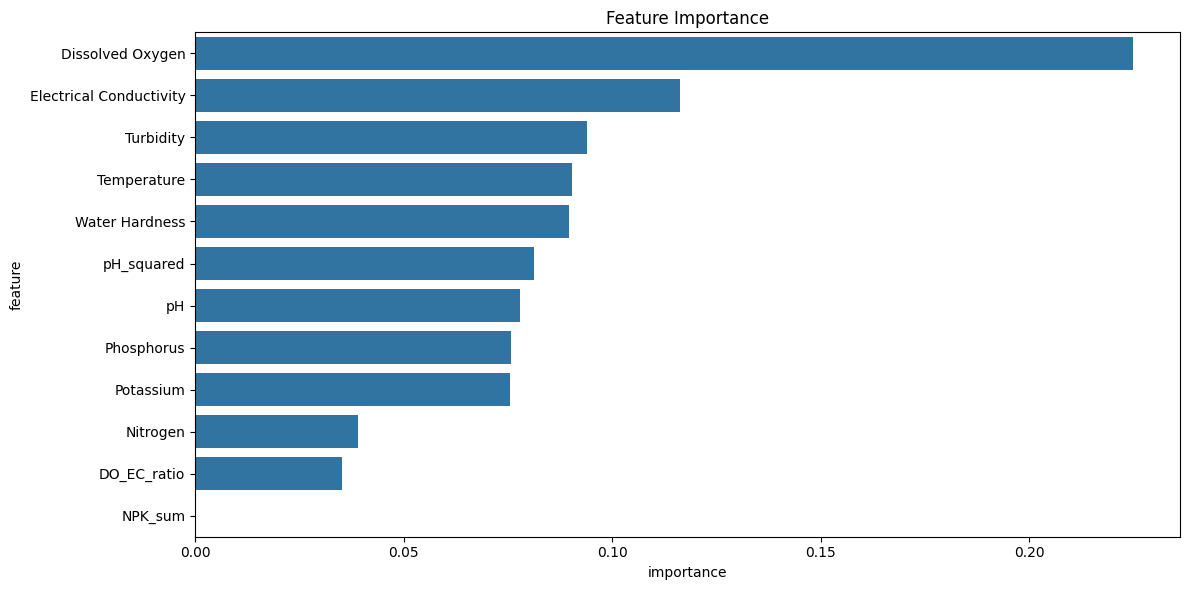

In [20]:
# Plot feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    importances = np.abs(best_model.coef_[0])
else:
    importances = None

if importances is not None:
    plt.figure(figsize=(12, 6))
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("Feature importance plot saved as 'feature_importance.png'")

Confusion matrix plot saved as 'confusion_matrix.png'


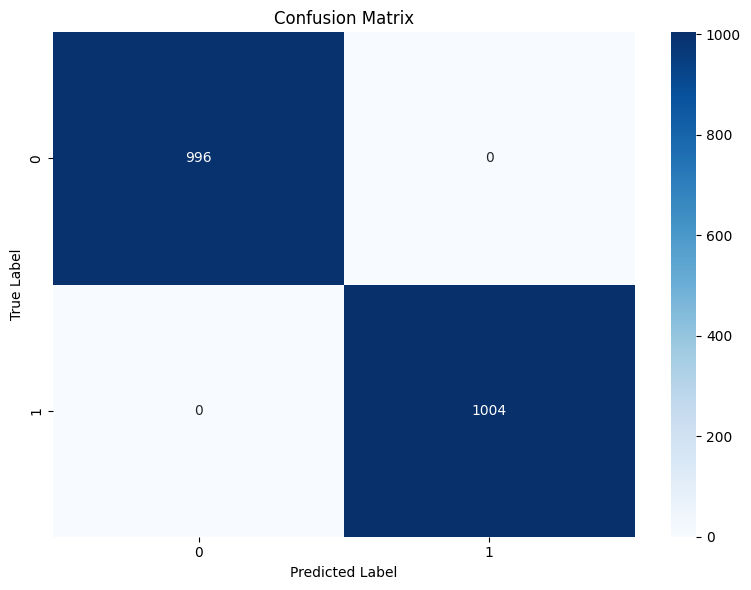

In [21]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix plot saved as 'confusion_matrix.png'")


In [22]:

# Example prediction
print("\nExample prediction:")
example = X_test.iloc[0]
prediction = pipeline.predict([example])
print(f"Water quality parameters: {example.to_dict()}")
print(f"Predicted label: {'Great for lettuce' if prediction[0] == 1 else 'Not great for lettuce'}")



Example prediction:
Water quality parameters: {'pH': 9.67, 'Temperature': 28.41, 'Dissolved Oxygen': 18.16, 'Electrical Conductivity': 1809.61, 'Turbidity': 7.06, 'Nitrogen': 50.87, 'Phosphorus': -2.97, 'Potassium': -0.24, 'Water Hardness': 127.32, 'pH_squared': 93.5089, 'DO_EC_ratio': 0.010035311475953382, 'NPK_sum': 47.66}
Predicted label: Not great for lettuce


c:\Users\UGH\Desktop\Water_Quality_monitoringV2\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [24]:
from joblib import dump, load

# Save model
dump(pipeline, '../models/trained/mdmc_modelv5.2.joblib')
print('Model has been saved and named "mdmc_model." ')

Model has been saved and named "mdmc_model." 
